In [30]:
import numpy as np
import pandas as pd
import re
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch import optim
import random
import transformers
from transformers import AutoModel, BertTokenizerFast, DistilBertTokenizer, DistilBertModel, DistilBertConfig
from torchinfo import summary
from sklearn.utils.class_weight import compute_class_weight

import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

In [33]:
# We have prepared a chitchat dataset with 5 labels
df = pd.read_csv("./data/intents.csv")
test_df = pd.read_csv("./data/test_intents.csv")
df.head()
print(df['Label'].value_counts())

# Converting the labels into encodings
le = LabelEncoder()
df['Label_Encoded'] = le.fit_transform(df['Label'])
test_df['Label_Encoded'] = le.fit_transform(test_df['Label'])
print(le)
print(le.classes_)
print(le.transform(le.classes_))
# check class distribution
df['Label_Encoded'].value_counts(normalize = True)

# In this example we have used all the utterances for training purpose
train_text, train_labels = df['Text'], df['Label_Encoded']
test_text, test_labels = test_df['Text'], test_df['Label_Encoded']

Genre       308
Time        104
Cast         52
Question     49
End          18
Start        18
Rating       14
Name: Label, dtype: int64
LabelEncoder()
['Cast' 'End' 'Genre' 'Question' 'Rating' 'Start' 'Time']
[0 1 2 3 4 5 6]


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


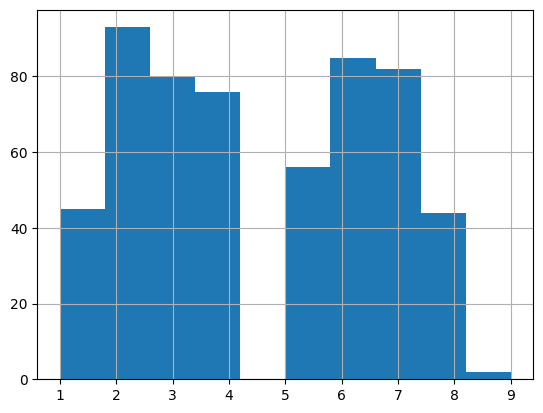

In [77]:
# # Load the BERT tokenizer
# tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
# # Import BERT-base pretrained model
# bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the DistilBert tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

configuration = DistilBertConfig(attention_dropout=0.5)
# Import the DistilBert pretrained model
bert = DistilBertModel(configuration).from_pretrained('distilbert-base-uncased')

# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]
pd.Series(seq_len).hist(bins = 10)

max_seq_len = 9

# tokenize and encode sequences in the training set
tokens_train = tokenizer(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

tokens_test = tokenizer(
    test_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())


#define a batch size
batch_size = 16
# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)
# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)
# DataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
test_data = TensorDataset(test_seq, test_mask, test_y)
# sampler for sampling the data during testing
test_sampler = RandomSampler(test_data)
# DataLoader for test set
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)
train_size = df.shape[0]
test_size = test_df.shape[0]

In [78]:
class BERT_Arch(nn.Module):
   def __init__(self, bert):      
       super(BERT_Arch, self).__init__()
       self.bert = bert 
      
       # dropout layer
       self.dropout = nn.Dropout(0.2)
      
       # relu activation function
       self.relu =  nn.ReLU()
       # dense layer
       self.fc1 = nn.Linear(768,512)
       self.fc2 = nn.Linear(512,256)
       self.fc3 = nn.Linear(256,7)
       #softmax activation function
       self.softmax = nn.LogSoftmax(dim=1)
       #define the forward pass
   def forward(self, sent_id, mask):
      #pass the inputs to the model  
      cls_hs = self.bert(sent_id, attention_mask=mask)[0][:,0]
      
      x = self.fc1(cls_hs)
      x = self.relu(x)
      x = self.dropout(x)
      
      x = self.fc2(x)
      x = self.relu(x)
      x = self.dropout(x)
      # output layer
      x = self.fc3(x)
   
      # apply softmax activation
      x = self.softmax(x)
      return x

In [79]:
# freeze all the parameters. This will prevent updating of model weights during fine-tuning.
for param in bert.parameters():
      param.requires_grad = False
model = BERT_Arch(bert)
# push the model to GPU
# model = model.to(device)
summary(model)

Layer (type:depth-idx)                                  Param #
BERT_Arch                                               --
├─DistilBertModel: 1-1                                  --
│    └─Embeddings: 2-1                                  --
│    │    └─Embedding: 3-1                              (23,440,896)
│    │    └─Embedding: 3-2                              (393,216)
│    │    └─LayerNorm: 3-3                              (1,536)
│    │    └─Dropout: 3-4                                --
│    └─Transformer: 2-2                                 --
│    │    └─ModuleList: 3-5                             (42,527,232)
├─Dropout: 1-2                                          --
├─ReLU: 1-3                                             --
├─Linear: 1-4                                           393,728
├─Linear: 1-5                                           131,328
├─Linear: 1-6                                           1,799
├─LogSoftmax: 1-7                                       --
Total 

In [82]:
# define the optimizer
optimizer = optim.AdamW(model.parameters(), lr = 1e-3)

#compute the class weights
class_wts = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
# print(class_wts)

# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
# loss function
cross_entropy = nn.NLLLoss(weight=weights) 
# We can also use learning rate scheduler to achieve better results
lr_sch = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)

In [83]:
# function to train the model
def train():
  
    model.train()
    total_loss = 0
    train_acc = 0
    # empty list to save model predictions
    total_preds=[]

    # iterate over batches
    for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
        # if step % 50 == 0 and not step == 0:
        # print(f'Batch {step}  of  {len(train_dataloader)}.')
        # push the batch to gpu
        # batch = [r.to(device) for r in batch] 
        sent_id, mask, labels = batch
        # get model predictions for the current batch
        preds = model(sent_id, mask)
        # compute the loss between actual and predicted values
        # print(preds, labels)
        loss = cross_entropy(preds, labels)
        # add on to the total loss
        total_loss = total_loss + loss.item()
        # backward pass to calculate the gradients
        loss.backward()
        # clip the the gradients to 1.0. It helps in preventing the    exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        # update parameters
        optimizer.step()
        # clear calculated gradients
        optimizer.zero_grad()

        # We are not using learning rate scheduler as of now
        # lr_sch.step()
        # model predictions are stored on GPU. So, push it to CPU
        # preds=preds.detach().cpu().numpy()
        # append the model predictions
        total_preds.append(preds.detach().numpy())
        # train accuracy
        _, train_predicted = torch.max(preds.data, 1)
        train_acc += (train_predicted == labels).sum().item()
    # compute the training loss of the epoch
    avg_loss = total_loss / len(train_dataloader)
    train_acc /= train_size
    
    # predictions are in the form of (no. of batches, size of batch, no. of classes).
    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)
    #returns the loss and predictions
    return avg_loss, total_preds, train_acc

# empty lists to store training and validation loss of each epoch
train_losses=[]
train_acc_arr = []
test_acc_arr = []
# number of training epochs
epochs = 200
print('train_losses len =', len(train_losses))
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _, train_acc = train()
    
    # append training and validation loss
    train_losses.append(train_loss)
    train_acc_arr.append(train_acc)
    # it can make your experiment reproducible, similar to set  random seed to all options where there needs a random seed.
    # torch.backends.cudnn.deterministic = True
    # torch.backends.cudnn.benchmark = False
    # ----------test----------
    model.eval()
    test_acc = 0.0
    for step, batch in enumerate(test_dataloader):
        sent_id, mask, labels = batch
        test_output = model(sent_id, mask)
        _, predicted = torch.max(test_output.data, 1)
        test_acc += (predicted == labels).sum().item()
    test_acc /= test_size
    test_acc_arr.append(test_acc)
    print(f'\nTraining Loss: {train_loss:.3f}; train_acc: {train_acc:.3f}; test_acc: {test_acc:.3f}')

torch.save(model.state_dict(), './trained_models/task_nlp_trained_test.pkl')

plt.plot([epoch for epoch in range(epochs)], train_losses)
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
# print(train_losses)

train_losses len = 0

 Epoch 1 / 200

Training Loss: 1.818; train_acc: 0.414; test_acc: 0.314

 Epoch 2 / 200

Training Loss: 1.305; train_acc: 0.679; test_acc: 0.300

 Epoch 3 / 200

Training Loss: 0.882; train_acc: 0.753; test_acc: 0.357

 Epoch 4 / 200

Training Loss: 0.673; train_acc: 0.803; test_acc: 0.400

 Epoch 5 / 200

Training Loss: 0.562; train_acc: 0.838; test_acc: 0.471

 Epoch 6 / 200


Text(0, 0.5, 'Training Loss')

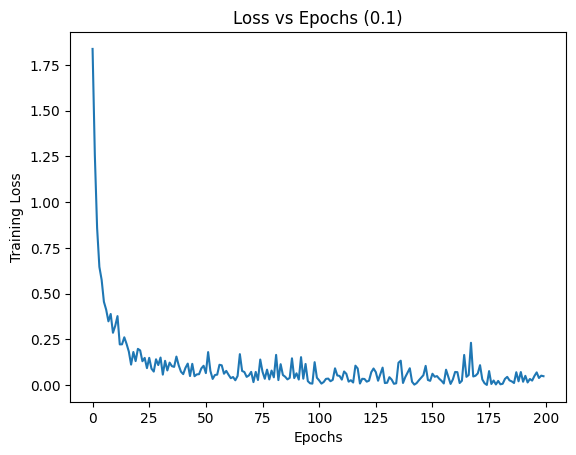

In [76]:
plt.plot([epoch for epoch in range(epochs)], train_losses)
plt.title('Loss vs Epochs (0.5)')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')

# plt.plot([epoch for epoch in range(epochs)], train_acc_arr, color='r', label='Training Accuracy')
# plt.plot([epoch for epoch in range(epochs)], test_acc_arr, color='b', label='Test Accuracy')
# plt.title('Accuracy vs Epochs (0.5)')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# print(train_losses)

In [11]:
def get_prediction(str):
    str = re.sub(r'[^a-zA-Z ]+', '', str)
    test_text = [str]
    model.eval()

    tokens_test_data = tokenizer(
    test_text,
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
    )
    test_seq = torch.tensor(tokens_test_data['input_ids'])
    test_mask = torch.tensor(tokens_test_data['attention_mask'])

    preds = model(test_seq, test_mask)
    preds = preds.detach().numpy()
    preds = np.argmax(preds, axis = 1)
    print('Intent Identified: ', le.inverse_transform(preds)[0])
    return le.inverse_transform(preds)[0]

In [61]:
movie_data = pd.read_csv('./data/movie_data.csv')
# movie_data.head()

KEYWORDS_TO_GENRE = {
    'scary': 'horror',
    'horror': 'horror',
}

BENCHMARK_YEAR = 2015
KEYWORDS_TO_TIME = {
    'now': '>',
    'present': '>',
    'new': '>',
    'latest': '>',
    'late': '>',
    'lately': '>',
    'young': '>',
    'recent': '>',
    'newest': '>',
    'past': '<',
    'old': '<',
    'oldest': '<',
    'early': '<',
    'earliest': '<',
}

BENCHMARK_RATING = 7.5

KEYWORDS_TO_RATING = {
    'good': '>',
    'great': '>',
    'excellent': '>',
    'atg': '>',
    'all time great': '>',
    'best': '>',
    'nice': '>',
    'top': '>',
    'bad': '<',
    'poor': '<',
    'worst': '<',
    'horrible': '<',
    'terrible': '<',
    'lousy': '<',
}

field_dictonary = {
  'Genre': KEYWORDS_TO_GENRE,
  'Time': KEYWORDS_TO_TIME,
  'Rating': KEYWORDS_TO_RATING
}

field_benchmark_dictionary = {
  'Time': BENCHMARK_YEAR,
  'Rating': BENCHMARK_RATING,
}

def find_field_value(field, values, inputDataFrame):
    """Returns the movies that match a particular genre

    Args:
        field (str): Fieldname to filter on
        values (list[str]): List of values

    Returns:
        pandas.DataFrame: A pandas dataframe filtered by the values input to the function
    """
    returnData = inputDataFrame
    for value in values:
       returnData = returnData[returnData[field].str.contains(value, regex=False)]
    return returnData

def find_relative_field(field, value, condition, inputDataFrame):
    """Returns the movies that match a particular genre

    Args:
        field (str): Fieldname to filter on
        values (list[str]): List of values

    Returns:
        pandas.DataFrame: A pandas dataframe filtered by the values input to the function
    """
    returnData = inputDataFrame
    if (condition == '>'):
        returnData = returnData[(returnData[field] > value)]
    elif (condition == '<'):
        returnData = returnData[(returnData[field] < value)]
    elif (condition == '<='):
        returnData = returnData[(returnData[field] <= value)]
    elif (condition == '>='):
        returnData = returnData[(returnData[field] >= value)]
    elif (condition == '=='):
        returnData = returnData[(returnData[field] == value)]
    return returnData

# find_field_value('Rating', ['James Gunn'])

def find_keywords_field(data_frame, message_arr, field, field_type):
  if field_type == 'VALUE':
    if field in field_dictonary:
      local_field_dict = field_dictonary[field]
      for i in message_arr:
        if i in local_field_dict:
          i = local_field_dict[i]
        if(find_field_value(field, [i.title()], data_frame).shape[0]) != 0:
          return find_field_value(field, [i.title()], data_frame)
    else:
      for i in message_arr:
        print(i)
        if(find_field_value(field, [i.title()], data_frame).shape[0]) != 0:
          print('inside if')
          return find_field_value(field, [i.title()], data_frame)
  elif field_type == 'RELATIVE':
    if field in field_dictonary:
      local_field_dict = field_dictonary[field]
      for i in message_arr:
        if i in local_field_dict:
          i = local_field_dict[i]
          print(i)
          if field in field_benchmark_dictionary:
            print(field)
            value = field_benchmark_dictionary[field]
            if(find_relative_field(field, value, i, data_frame).shape[0]) != 0:
              return find_relative_field(field, value, i, data_frame)
    else:
      for i in message_arr:
        print(i)
        if(find_relative_field(field, value, i, data_frame).shape[0]) != 0:
          print('inside if')
          return find_relative_field(field, value, i, data_frame)


movie_data[(movie_data['Year'] > 2020)]

def get_response(): 
  movie_data = pd.read_csv('./data/movie_data.csv')
  movie_data.head()

  while True:
    message = input('Say something to start')
    intent = get_prediction(message).lower()
    message_arr = message.split(' ')
    # intent_list = df['Label'].unique()
    response = 'Sorry, could you repeat that again'
    if intent == 'start':
      response = 'Hello, ask me for movie recommendations!'
    elif intent == 'question':
      response = 'What genre would you like?'
    elif intent == 'genre':
      movie_data = find_keywords_field(movie_data, message_arr, 'Genre', 'VALUE')
      response = 'how old should the movie be?'
    elif intent == 'time':

      response = 'whose movies would you like to watch'
    elif intent == 'cast':
      movie_data = find_keywords_field(movie_data, message_arr, 'Actors', 'VALUE')
    elif intent == 'end':
      response = 'Goodbye!'
      print(movie_data)
      print(response)
      return movie_data
    print(response)

# print(movie_data[(movie_data['Year'] > 2020)])

# get_response()
# print(find_field_value('Genre', ['Horror'], movie_data))
# print(find_keywords_field(movie_data, ['Christian'], 'Actors', 'VALUE'))
print(find_keywords_field(movie_data, ['great'], 'Rating', 'RELATIVE'))
# print(movie_data[movie_data['Cast']])

for i in range(7):
    print(le.inverse_transform([i]))



>
Rating
     Rank                           Title                       Genre  \
0       1         Guardians of the Galaxy     Action,Adventure,Sci-Fi   
6       7                      La La Land          Comedy,Drama,Music   
11     12                  Hidden Figures     Biography,Drama,History   
12     13                       Rogue One     Action,Adventure,Sci-Fi   
13     14                           Moana  Animation,Adventure,Comedy   
..    ...                             ...                         ...   
950   951  Me and Earl and the Dying Girl                Comedy,Drama   
957   958                    End of Watch        Crime,Drama,Thriller   
959   960             Lucky Number Slevin         Crime,Drama,Mystery   
979   980              The Skin I Live In              Drama,Thriller   
991   992                Taare Zameen Par          Drama,Family,Music   

                                           Description             Director  \
0    A group of intergalactic crimi